In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
import quandl
import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

quandl.ApiConfig.api_key = "eRvW6fEn_RcPcsJVjuNp"

amzn = quandl.get('WIKI/AMZN', qopts={'columns': ['Date']})
amzn = amzn.reset_index()
amzn['Date'] = pd.to_datetime(amzn['Date'],format='%Y-%m-%d')
amzn = amzn.set_index('Date') 

In [14]:
# Get competitor data for the same date range
start = amzn.first_valid_index()
end = amzn.last_valid_index()
wmt = quandl.get('WIKI/WMT', qopts={'columns': ['Date']})
wmt = wmt.reset_index()
wmt['Date'] = pd.to_datetime(wmt['Date'],format='%Y-%m-%d')
wmt = wmt.loc[wmt['Date']>=start]
wmt = wmt.loc[wmt['Date']<=end]
wmt.rename(columns={'Volume':'WMT Volume'}, inplace=True)
# Get 5 day moving average
wmt['WMT Moving Avg.'] = wmt.loc[:,'Adj. Close'].rolling(window=5).mean()
wmt_ma = wmt.loc[:,['Date','WMT Moving Avg.', 'WMT Volume']]
wmt_ma

,Date,WMT Moving Avg.,WMT Volume
6247,1997-05-16,NaN,4688900.0
6248,1997-05-19,NaN,2305700.0
6249,1997-05-20,NaN,2128200.0
6250,1997-05-21,NaN,3646000.0
6251,1997-05-22,10.823585,2051800.0
...,...,...,...
11491,2018-03-21,88.052000,11687930.0
11492,2018-03-22,87.978000,11338049.0
11493,2018-03-23,87.228000,9762296.0
11494,2018-03-26,87.238000,8640866.0


In [20]:
# Merge competitor data
amzn = pd.merge(amzn, wmt_ma, on='Date')
amzn = amzn.set_index('Date')
df = amzn.loc[:,['Adj. Close', 'Volume', 'WMT Moving Avg.', 'WMT Volume_x']]

# Get 5 day moving average
df['Moving Avg.'] = amzn.loc[:,'Adj. Close'].rolling(window=5).mean()
df.head()

,Adj. Close,Volume,WMT Moving Avg.,WMT Volume_x,WMT Volume_x,WMT Volume_x,WMT Volume_x,Moving Avg.
Date,,,,,,,,
1997-05-16,1.729167,1225000.0,NaN,4688900.0,4688900.0,4688900.0,4688900.0,NaN
1997-05-19,1.708333,508900.0,NaN,2305700.0,2305700.0,2305700.0,2305700.0,NaN
1997-05-20,1.635833,455600.0,NaN,2128200.0,2128200.0,2128200.0,2128200.0,NaN
1997-05-21,1.427500,1571100.0,NaN,3646000.0,3646000.0,3646000.0,3646000.0,NaN
1997-05-22,1.395833,981400.0,NaN,2051800.0,2051800.0,2051800.0,2051800.0,1.579333


In [12]:
# Backfill missing values
df.fillna(method='bfill', inplace=True)

# Separating 10 records to predict.
df['Pred. Close'] = df['Adj. Close'].shift(-10)
x = np.array(df.drop(['Pred. Close'], 1))
x_predict = x[-10:]
x = x[:-10]
y = np.array(df['Pred. Close'])
y = y[:-10]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.002, random_state=100)

# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

conf_score = lin_reg.score(x_test, y_test)
print('Confidence Score is ', conf_score)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [5]:
predicted_values = lin_reg.predict(x_predict)
df['Forecast'] = np.nan

In [6]:
last_date = df.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in predicted_values:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]



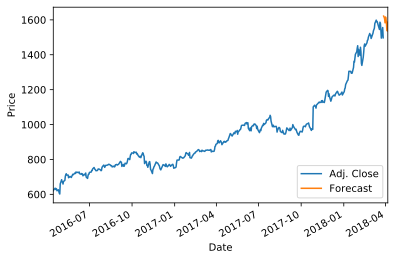

In [7]:
df['Adj. Close'].tail(500).plot()
df['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()